# Bias Reduction

Climate models can have biases towards different references. Commonly, biases are reduced by postprocessing before verification of forecasting skill. `climpred` provides convenience functions to do so.

In [1]:
import climpred
import xarray as xr
import matplotlib.pyplot as plt
from climpred import HindcastEnsemble
hind = climpred.tutorial.load_dataset('CESM-DP-SST') # CESM-DPLE hindcast ensemble output.
obs = climpred.tutorial.load_dataset('ERSST') # ERSST observations.
recon = climpred.tutorial.load_dataset('FOSI-SST') # Reconstruction simulation that initialized CESM-DPLE.
hind["lead"].attrs["units"] = "years"
v='SST'
alignment='same_verif'

In [2]:
hindcast = HindcastEnsemble(hind)
# choose one observation
hindcast = hindcast.add_observations(recon, 'reconstruction')
#hindcast = hindcast.add_observations(obs, 'ERSST') # fits hind better than reconstruction

/Users/aaron.spring/anaconda3/envs/climpred-dev/lib/python3.6/site-packages/climpred-2.0.0.post40+dirty-py3.6.egg/climpred/utils.py:141: UserWarning: Assuming annual resolution due to numeric inits. Change init to a datetime if it is another resolution.
  'Assuming annual resolution due to numeric inits. '


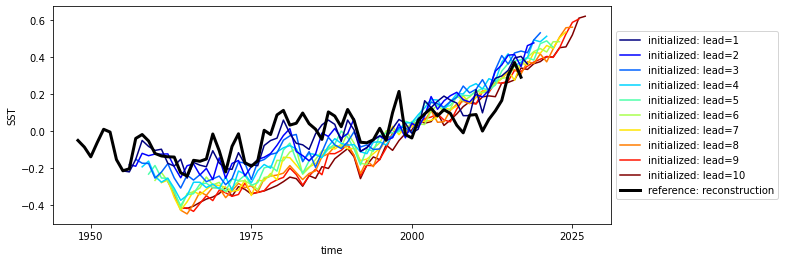

In [3]:
# always only subtract a PredictionEnsemble from another PredictionEnsemble if you handle time and init at the same time
# compute anomaly with respect to 1964-2014
hindcast = hindcast - hindcast.sel(time=slice('1964', '2014')).mean('time').sel(init=slice('1964', '2014')).mean('init')
hindcast.plot()

The warming of the `reconstruction` is less than the `initialized`.

## Mean bias reduction

Typically, bias depends on lead-time and therefore should therefore also be removed depending on lead-time.

In [4]:
# build bias_metric by hand
from climpred.metrics import Metric
def bias_func(a,b,**kwargs):
    return a-b
bias_metric = Metric('bias', bias_func, True, False,1)

In [5]:
bias = hindcast.verify(metric=bias_metric, comparison='e2r', dim='init', alignment=alignment).squeeze()

In [6]:
# equals using the pre-defined (unconditional) bias metric applied to over dimension member
xr.testing.assert_allclose(bias, hindcast.verify(metric='unconditional_bias', comparison='m2r',dim='member', alignment=alignment).squeeze())

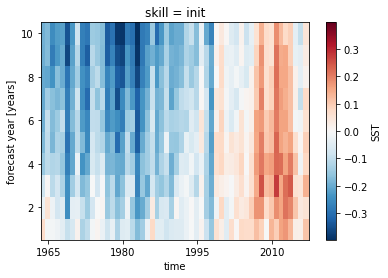

In [7]:
bias[v].plot()

- against Reconstruction: Cold bias in early years and warm bias in later years.
- against ERSST: Overall cold bias.

### cross validatation

In [8]:
from climpred.bias_reduction import _mean_bias_reduction_quick, _mean_bias_reduction_cross_validate

In [9]:
_mean_bias_reduction_quick??

Signature: _mean_bias_reduction_quick(hind, bias, dim)
Source:   
def _mean_bias_reduction_quick(hind, bias, dim):
    """Quick reduction of mean bias over all initializations.

    Args:
        hind (xr.object): hindcast.
        bias (xr.object): bias.
        dim (str): Time dimension name in bias.

    Returns:
        xr.object: bias reduced hind

    """
    bias_reduced_hind = hind - bias.mean(dim)
    return bias_reduced_hind
File:      ~/anaconda3/envs/climpred-dev/lib/python3.6/site-packages/climpred-2.0.0.post40+dirty-py3.6.egg/climpred/bias_reduction.py
Type:      function


In [10]:
_mean_bias_reduction_cross_validate??

Signature: _mean_bias_reduction_cross_validate(hind, bias, dim)
Source:   
def _mean_bias_reduction_cross_validate(hind, bias, dim):
    """Reduce mean bias from all but the given initialization (cross-validation).

    .. note::
        This method follows Jolliffe 2011. For a given initialization, bias is computed
        over all other initializations, excluding the one in question. This calculated
        bias is removed from the given initialization, and then the process proceeds to
        the following one.

    Args:
        hind (xr.object): hindcast.
        bias (xr.object): bias.
        dim (str): Time dimension name in bias.

    Returns:
        xr.object: bias reduced hind

    Reference:
        * Jolliffe, Ian T., and David B. Stephenson. Forecast Verification: A
          Practitioner’s Guide in Atmospheric Science. Chichester, UK: John Wiley &
          Sons, Ltd, 2011. https://doi.org/10.1002/9781119960003., Chapter: 5.3.1, p.80
    """
    bias = bias.rename({dim:

`climpred` wraps these functions in `HindcastEnsemble.reduce_bias(how='mean', cross_validate={bool})`.

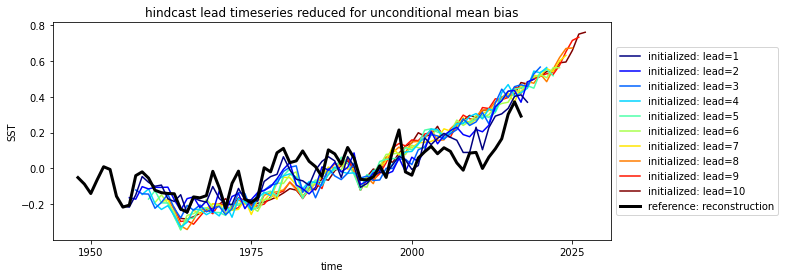

In [11]:
hindcast.reduce_bias(how='mean', cross_validate=True, alignment=alignment).plot()
plt.title('hindcast lead timeseries reduced for unconditional mean bias')
plt.show()

# Skill

Distance-based accuracy metrics like (`mse`,`rmse`,`nrmse`,...) are sensitive to mean bias reduction. Correlations like (`pearson_r`, `spearman_r`) are insensitive to bias correction.

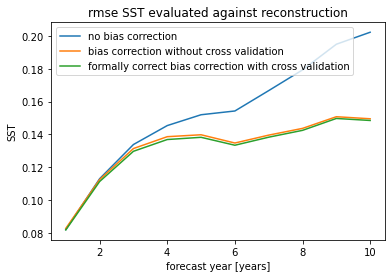

In [12]:
metric='rmse'
hindcast.verify(metric=metric, alignment=alignment)[v].plot(label='no bias correction')
hindcast.reduce_bias(cross_validate=False, alignment=alignment).verify(metric=metric, alignment=alignment)[v].plot(label='bias correction without cross validation')
hindcast.reduce_bias(cross_validate=True, alignment=alignment).verify(metric=metric, alignment=alignment)[v].plot(label='formally correct bias correction with cross validation')
plt.legend()
plt.title(f"{metric} {v} evaluated against {list(hindcast._datasets['observations'].keys())[0]}")
plt.show()